In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
import os
import folium
import matplotlib.pyplot as plt
import mapclassify as mc
import regex as re
import seaborn as sns
from random import choices
from sklearn.utils import shuffle
import matplotlib as plt

## Importing Data
district_geodf: Shapefile of the geographic locations of the school district in California <br>
education_df: Different educational attainment rates for school districts in California<br>
education_data: Demographic racial data of various students broken down by school district in California better data set for joining onto geodataframe<br>
expense_data: Spending data for various school districts<br>
race_data:Demographic racial data of various students broken down by school district in California used to create percent distributions per school district<br>

In [2]:
district_geodf = gp.read_file("California_School_District_Areas_2018-19.zip")
education_df = pd.read_csv("cohort2021.txt", sep="\t")
education_data = pd.read_csv("CDP05_101_04000US06_101515523495.txt", sep="|")
expense_data = pd.read_csv('currentexpense2021.csv')
race_data = pd.read_csv('district_rate_data.csv')

## Data Cleaning
To get a better understanding of the data instead of raw numbers getting percentages of each racial group per district helps to give a better understanding of the racial breakdown of each district that looking at raw numbers can not give.

In [3]:
race_data.columns = ['Name', 'State','District ID', 'Union ID', 'District Type', 'Status', 
                     'American Indian and Alaska Native','Asian', 'Hispanic', 'Black',
                     'White', 'Hawaiian/Pacific Islander', 'Multiracial','Total']

race_data = race_data.replace('=', '',regex = True)
race_data = race_data.replace('"', '', regex = True)
race_data = race_data.replace('–', 0)
race_data = race_data.replace('†', 0)
race_data = race_data.replace('‡', 0)
for c in race_data.columns[6:13]:
    race_column = c + ' %'
    race_data[race_column] = race_data[c].values.astype(int) / race_data['Total'].values.astype(int)

<ipython-input-3-52b5fa7b90f7>:12: RuntimeWarning: invalid value encountered in true_divide
  race_data[race_column] = race_data[c].values.astype(int) / race_data['Total'].values.astype(int)
<ipython-input-3-52b5fa7b90f7>:12: RuntimeWarning: invalid value encountered in true_divide
  race_data[race_column] = race_data[c].values.astype(int) / race_data['Total'].values.astype(int)
<ipython-input-3-52b5fa7b90f7>:12: RuntimeWarning: invalid value encountered in true_divide
  race_data[race_column] = race_data[c].values.astype(int) / race_data['Total'].values.astype(int)
<ipython-input-3-52b5fa7b90f7>:12: RuntimeWarning: invalid value encountered in true_divide
  race_data[race_column] = race_data[c].values.astype(int) / race_data['Total'].values.astype(int)
<ipython-input-3-52b5fa7b90f7>:12: RuntimeWarning: invalid value encountered in true_divide
  race_data[race_column] = race_data[c].values.astype(int) / race_data['Total'].values.astype(int)
<ipython-input-3-52b5fa7b90f7>:12: RuntimeWar

In [4]:
race_data.head()

,Name,State,District ID,Union ID,District Type,Status,American Indian and Alaska Native,Asian,Hispanic,Black,...,Hawaiian/Pacific Islander,Multiracial,Total,American Indian and Alaska Native %,Asian %,Hispanic %,Black %,White %,Hawaiian/Pacific Islander %,Multiracial %
0,ABC UNIFIED,California,0601620,,1-Regular local school district that is NOT a ...,1-Open,50,6900,8886,1525,...,109,1015,19540,0.002559,0.353122,0.454759,0.078045,0.053992,0.005578,0.051945
1,ACADEMIA AVANCE CHARTER DISTRICT,CALIFORNIA,0602291,,7-Independent Charter District,1-Open,0,5,268,2,...,0,15,293,0.000000,0.017065,0.914676,0.006826,0.010239,0.000000,0.051195
2,ACADEMIA MODERNA DISTRICT,CALIFORNIA,0602361,,7-Independent Charter District,1-Open,0,0,440,1,...,0,2,446,0.000000,0.000000,0.986547,0.002242,0.006726,0.000000,0.004484
3,ACADEMY FOR ACADEMIC EXCELLENCE DISTRICT,CALIFORNIA,0601911,,7-Independent Charter District,1-Open,8,78,588,40,...,1,117,1466,0.005457,0.053206,0.401091,0.027285,0.432469,0.000682,0.079809
4,ACADEMY OF MEDIA ARTS DISTRICT,CALIFORNIA,0602503,,7-Independent Charter District,1-Open,0,1,16,33,...,0,13,63,0.000000,0.015873,0.253968,0.523810,0.000000,0.000000,0.206349


#### Race Dataframe Renaming
Data from California Department of Education uses codes for different groups and also contains different symbols in their csv files so we need to remove them to make it easier to manipulate when exported

In [5]:
Race_df = education_data[['GeoId', 'CDP05_14est', 'CDP05_15est', 'CDP05_16est', 'CDP05_18est', 'CDP05_19est', 'CDP05_20est', 'CDP05_25est', 'CDP05_33est', 'CDP05_38est', 'CDP05_52est', 'CDP05_58est']]
Race_df.columns = ['GeoId', 'Total population', 'One Race population', 'Two or more race population', 'White population', 'Black or African American population', 'American Indian and Alaska Native population', 'Asian population', 'Native Hawaiian and Other Pacific Islander population', 'Some Other Race population', 'Hispanic or Latino population', 'White and Not Hispanic or Latino population']
#Race_df['Total population'] = Race_df['Total population'] + Race_df['Hispanic or Latino population']
#Race_df['One Race population'] = Race_df['One Race population'] + Race_df['Hispanic or Latino population']
Race_df['FullCode'] = ["0" + str(x) if len(str(x)) == 6 else x for x in education_data["LEAID"].values]


<ipython-input-5-de8cf4435713>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Race_df['FullCode'] = ["0" + str(x) if len(str(x)) == 6 else x for x in education_data["LEAID"].values]


In [6]:
Race_df.head()

,GeoId,Total population,One Race population,Two or more race population,White population,Black or African American population,American Indian and Alaska Native population,Asian population,Native Hawaiian and Other Pacific Islander population,Some Other Race population,Hispanic or Latino population,White and Not Hispanic or Latino population,FullCode
0,97000US0600001,2220,2135,85,1885,10,0,55,0,185,635,1435,0600001
1,97000US0600153,20635,19490,1145,3650,460,10,9200,215,5950,9495,750,0600153
2,97000US0600017,22070,20190,1880,17415,1560,190,330,0,700,11015,8425,0600017
3,95000US0603000,1475,1300,180,1110,45,10,60,0,75,215,1015,0603000
4,95000US0603060,825,780,45,590,15,65,40,10,50,235,415,0603060


#### Creating Full District Codes
Schools in the United States use a full code system in which different sections of the code represent the locality taking the county code column and combining with the district code column allows us to join this information with the 'district_geodf' to create a fully exportable shapefile

In [7]:
#Adding a county code based on the contents of the dataframe

education_df["CountyCode"] = education_df["CountyCode"].values.astype(str)
education_df["CountyCode"] = ["0" + x if len(x) == 1 else x for x in education_df["CountyCode"].values]

In [8]:
#Making a full code based on the district code plus the county code
education_df = education_df[education_df['AggregateLevel']=="D"]

education_df["DistrictCode"] = education_df["DistrictCode"].values.astype(int)
education_df["DistrictCode"] = education_df["DistrictCode"].values.astype(str)
education_df["DistrictCode"] = ["0" + x if len(x) == 4 else x for x in education_df["DistrictCode"].values]
education_df["FullCode"] = education_df["CountyCode"] + education_df["DistrictCode"]
education_df.head()

,AcademicYear,AggregateLevel,CountyCode,DistrictCode,SchoolCode,CountyName,DistrictName,SchoolName,CharterSchool,DASS,...,SPED Certificate (Rate),GED Completer (Count),GED Completer (Rate),Other Transfer (Count),Other Transfer (Rate),Dropout (Count),Dropout (Rate),Still Enrolled (Count),Still Enrolled (Rate),FullCode
8531,2020-21,D,01,10017,0.0,Alameda,Alameda County Office of Education,District Office,All,All,...,0.0,0,0.0,0,0.0,35,21.6,21,13.0,0110017
8532,2020-21,D,01,10017,0.0,Alameda,Alameda County Office of Education,District Office,All,All,...,0.0,0,0.0,0,0.0,75,41.0,22,12.0,0110017
8533,2020-21,D,01,10017,0.0,Alameda,Alameda County Office of Education,District Office,All,All,...,*,*,*,*,*,*,*,*,*,0110017
8534,2020-21,D,01,10017,0.0,Alameda,Alameda County Office of Education,District Office,All,All,...,0.0,0,0.0,0,0.0,45,36.6,15,12.2,0110017
8535,2020-21,D,01,10017,0.0,Alameda,Alameda County Office of Education,District Office,All,All,...,*,*,*,*,*,*,*,*,*,0110017


#### Filtering Districts and Columns
Creating different dataframes in which we rename the columns to show the various educational attainment rates for each school to compare and separate into data for charter schools, without charter schools, and combined to create comparison graphs between all of them. We exclude DASS in this case as they are a special type of school from both.  

In [9]:
education_columns =  ['AcademicYear', 'AggregateLevel', 'CountyCode', 'DistrictCode', 'SchoolCode', 'CountyName', 'DistrictName', 'SchoolName', 'CharterSchool', 'DASS', 'ReportingCategory', 'CohortStudents', 'Regular HS Diploma Graduates (Rate)', "Met UC/CSU Grad Req's (Rate)", 'Seal of Biliteracy (Rate)', 'Golden State Seal Merit Diploma (Rate', 'CHSPE Completer (Rate)', 'Adult Ed. HS Diploma (Rate)', 'SPED Certificate (Rate)', 'GED Completer (Rate)', 'Other Transfer (Rate)', 'Dropout (Rate)', 'Still Enrolled (Rate)', 'FullCode']
Education_df = education_df[education_columns]
Education_df = Education_df.rename(columns={"Golden State Seal Merit Diploma (Rate": "Golden State Seal Merit Diploma (Rate)"})

In [10]:
without_charter_education = Education_df.copy()
with_charter_education = Education_df.copy()
only_charter_education = Education_df.copy()


without_charter_education = without_charter_education[without_charter_education['ReportingCategory']=="TA"]
without_charter_education = without_charter_education[without_charter_education['CharterSchool']=="No "]
without_charter_education = without_charter_education[without_charter_education['DASS']=="All"]

with_charter_education = with_charter_education[with_charter_education['ReportingCategory']=="TA"]
with_charter_education = with_charter_education[with_charter_education['CharterSchool']=="All"]
with_charter_education = with_charter_education[with_charter_education['DASS']=="All"]

only_charter_education = only_charter_education[only_charter_education['ReportingCategory']=="TA"]
only_charter_education = only_charter_education[only_charter_education['CharterSchool']=="Yes"]
only_charter_education = only_charter_education[only_charter_education['DASS']=="All"]

without_charter_education.head()

,AcademicYear,AggregateLevel,CountyCode,DistrictCode,SchoolCode,CountyName,DistrictName,SchoolName,CharterSchool,DASS,...,Seal of Biliteracy (Rate),Golden State Seal Merit Diploma (Rate),CHSPE Completer (Rate),Adult Ed. HS Diploma (Rate),SPED Certificate (Rate),GED Completer (Rate),Other Transfer (Rate),Dropout (Rate),Still Enrolled (Rate),FullCode
8598,2020-21,D,01,10017,0.0,Alameda,Alameda County Office of Education,District Office,No,All,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.9,9.5,0110017
8714,2020-21,D,01,31609,0.0,Alameda,California School for the Blind (State Special...,District Office,No,All,...,0.0,0.0,0.0,0.0,36.4,0.0,0.0,63.6,0.0,0131609
8775,2020-21,D,01,31617,0.0,Alameda,California School for the Deaf-Fremont (State ...,District Office,No,All,...,33.3,29.2,0.0,0.0,5.3,0.0,0.0,2.6,28.9,0131617
8860,2020-21,D,01,61119,0.0,Alameda,Alameda Unified,District Office,No,All,...,16.7,49.8,1.1,0.0,1.5,0.0,0.1,3.0,3.3,0161119
9012,2020-21,D,01,61127,0.0,Alameda,Albany City Unified,District Office,No,All,...,20.6,1.4,1.0,0.0,0.3,0.0,0.0,3.7,0.0,0161127


#### Exporting Data
Combine all the data with geographical dataframes to export shapefiles to be used in Tableau

In [11]:
district_geodf['CDCodeint'] = pd.to_numeric(district_geodf['CDCode']) 

In [12]:
geo_with_charter_info = district_geodf.merge(with_charter_education, left_on = 'CDCode', right_on = 'FullCode')
geo_only_charter_info = district_geodf.merge(only_charter_education, left_on = 'CDCode', right_on = 'FullCode')
geo_without_charter_info = district_geodf.merge(without_charter_education, left_on = 'CDCode', right_on = 'FullCode')

In [13]:
districts_demographics = district_geodf.merge(Race_df, left_on = 'FedID', right_on= 'FullCode')

In [14]:
districts_demographics_only_charter = districts_demographics.merge(only_charter_education, left_on = 'CDCode', right_on = 'FullCode')

In [15]:
districts_demographics.to_file(filename='districts_demographics.shp')
geo_with_charter_info.to_file(filename='with_charter.shp')
geo_only_charter_info.to_file(filename='only_charter.shp')
geo_without_charter_info.to_file(filename='without_charter.shp')

C:\Users\jdand\anaconda3\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
<ipython-input-15-a15f791a666d>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  districts_demographics.to_file(filename='districts_demographics.shp')
C:\Users\jdand\anaconda3\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
<ipython-input-15-a15f791a666d>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_with_charter_info.to_file(filename='with_charter.shp')
C:\Users\jdand\anaconda3\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and

#### A/B Testing
Creating a dataframe to perform an A/B test to see if there is a difference between dropout rates for charter schools and non-charter schools.We drop null values due to specific school districts not having enough information, converting to float, and dropping values equal to 0 as that identifies missing information as well.

In [16]:
charter_and_no_charter = Education_df[(Education_df['CharterSchool'] == 'No ') | (Education_df['CharterSchool'] == 'Yes')]
charter_and_no_charter = charter_and_no_charter[charter_and_no_charter['ReportingCategory']=="TA"]
charter_and_no_charter = charter_and_no_charter[['Dropout (Rate)','CharterSchool']]

<AxesSubplot:xlabel='Dropout (Rate)', ylabel='Count'>

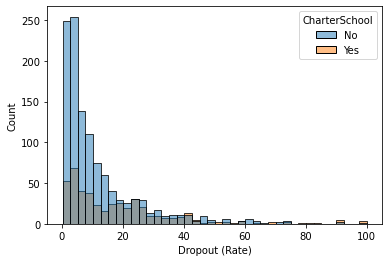

In [17]:
charter_and_no_charter = charter_and_no_charter[charter_and_no_charter['Dropout (Rate)'] != '*']
charter_and_no_charter['Dropout (Rate)'] = charter_and_no_charter['Dropout (Rate)'].astype(float)
charter_and_no_charter = charter_and_no_charter[(charter_and_no_charter['Dropout (Rate)'] != 0)]
test_stat = np.mean(charter_and_no_charter[charter_and_no_charter['CharterSchool'] == 'Yes']['Dropout (Rate)']) - np.mean(
    charter_and_no_charter[charter_and_no_charter['CharterSchool'] == 'No ']['Dropout (Rate)'])
sns.histplot(data = charter_and_no_charter, x = 'Dropout (Rate)', hue = 'CharterSchool')

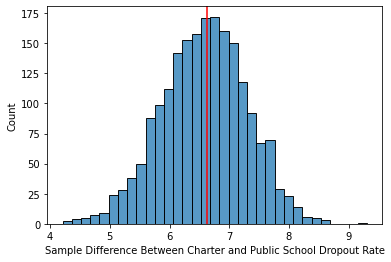

In [18]:
# Generate samples that can be plotted to see any differences in dropout rates
def sample_charter(df,sample_size):
    charter_labels = []
    droprates = []
    yes_charter = choices(df[df['CharterSchool'] == 'Yes']['Dropout (Rate)'].values, k = sample_size)
    no_charter = choices(df[df['CharterSchool'] == 'No ']['Dropout (Rate)'].values, k = sample_size)
    return np.abs(np.mean(yes_charter) - np.mean(no_charter))

iterations = 2000
sample_stats = []
for i in np.arange(iterations):
    sample_stat = sample_charter(charter_and_no_charter,1000)
    sample_stats.append(sample_stat)

ax = sns.histplot(sample_stats)
ax.set(xlabel ='Sample Difference Between Charter and Public School Dropout Rate')
ax.axvline(test_stat, color = 'red')

In [19]:
print('P-value is: '+str(sum([x > test_stat for x in sample_stats])/iterations))

P-value is: 0.4865


#### Conclusions
Our alternative hypothesis was that charter schools and public schools do not have the same dropout rate. Creating random samples we have gotten a value far above the normal p-value threshold of 0.05 meaning that reject the null hypothesis that there is no difference in dropout rates and based on the test statistic (Charter Dropout - Public Dropout) we see charters actually have a higher dropout rate.


#### Expense Data
We also want to explore the difference between the two types of schools and using Expense Per ADA which measures the average daily attendence cost we can roughly see a schools expenditures. A rough plot is provided to see the general distibution versus the dropout rate.

In [20]:
expense_data_full = expense_data.copy()
expense_data_full['CO'] = ["0" + str(x) if len(str(x)) == 1 else str(x) for x in expense_data_full["CO"].values]
expense_data_full['CDS'] = ["0" + str(x) if len(str(x)) == 1 else str(x) for x in expense_data_full["CDS"].values]
expense_data_full['FullCode'] = expense_data_full['CO'] + expense_data_full['CDS'] 
expense_data_full

,CO,CDS,DISTRICT,EDP 365,Current\nExpense ADA,Current\nExpense Per ADA,LEA Type,FullCode
0,01,61119,Alameda Unified,"122,421,584.91","8,975.20","13,639.98",Unified,0161119
1,01,61127,Albany City Unified,"47,343,135.51","3,484.19","13,587.99",Unified,0161127
2,01,61143,Berkeley Unified,"173,753,016.19","9,426.03","18,433.32",Unified,0161143
3,01,61150,Castro Valley Unified,"105,286,407.91","8,976.77","11,728.76",Unified,0161150
4,01,61168,Emery Unified,"12,731,320.51",688.6,"18,488.70",Unified,0161168
...,...,...,...,...,...,...,...,...
932,58,72728,Camptonville Elementary,"875,381.07",46.78,"18,712.72",Elementary,5872728
933,58,72736,Marysville Joint Unified,"115,960,984.35","9,148.96","12,674.77",Unified,5872736
934,58,72744,Plumas Lake Elementary,"14,618,900.19","1,322.56","11,053.49",Elementary,5872744
935,58,72751,Wheatland,"17,142,611.09","1,247.16","13,745.32",Elementary,5872751


In [21]:
geo_expense_data = district_geodf.merge(expense_data_full, left_on = 'CDCode', right_on = 'FullCode')[['CO', 'CDS', 'DISTRICT', 'EDP 365', 'Current\nExpense ADA',
       'Current\nExpense Per ADA', 'LEA Type', 'FullCode','geometry']]

In [22]:
charter_and_public = Education_df[(Education_df['CharterSchool'] == 'No ') | (Education_df['CharterSchool'] == 'Yes')]
charter_and_public = charter_and_public[charter_and_public['ReportingCategory']=="TA"]
expense_education_data = expense_data_full.merge(charter_and_public, left_on = 'FullCode', right_on ='FullCode')
expense_education_data = expense_education_data.replace(',','', regex=True)
expense_education_data['Current\nExpense Per ADA'] = expense_education_data['Current\nExpense Per ADA'].astype(float)
expense_education_data['Dropout (Rate)'] = expense_education_data['Dropout (Rate)'].replace('*','0').astype(float)
expense_education_data = expense_education_data[expense_education_data['Dropout (Rate)'] != 0]

In [23]:
expense_education_data.to_csv('expense_education_data.csv')
race_data.to_csv('race_population_district_data.csv')

<AxesSubplot:xlabel='Current\nExpense Per ADA', ylabel='Dropout (Rate)'>

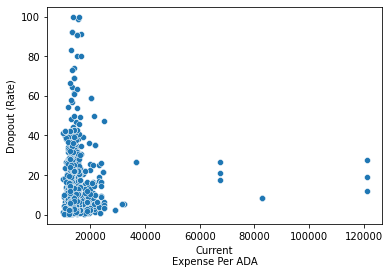

In [24]:
sns.scatterplot(data = expense_education_data, x = 'Current\nExpense Per ADA', y='Dropout (Rate)')